In [8]:
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)

# Kalman
x_n = a * x_n-1 + noise

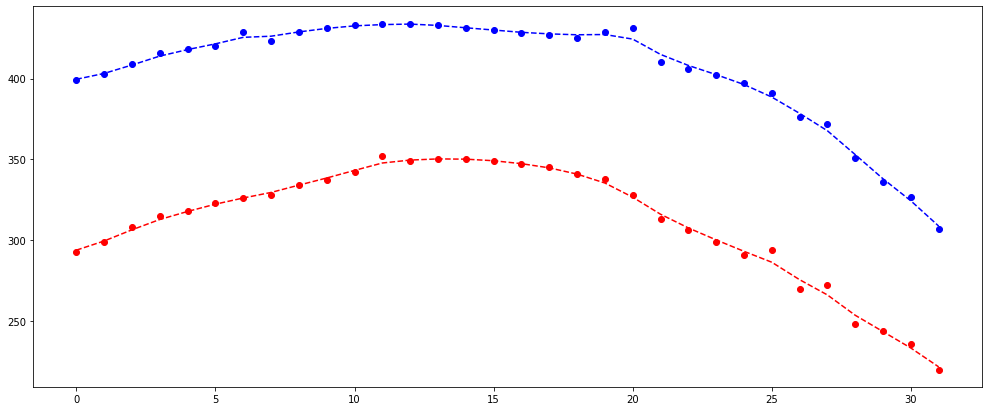

In [12]:
from pykalman import KalmanFilter
import time

measurements = np.asarray([(399,293),(403,299),(409,308),(416,315),(418,318),(420,323),(429,326),(423,328),(429,334),(431,337),(433,342),(434,352),(434,349),(433,350),(431,350),(430,349),(428,347),(427,345),(425,341),(429,338),(431,328),(410,313),(406,306),(402,299),(397,291),(391,294),(376,270),(372,272),(351,248),(336,244),(327,236),(307,220)])

initial_state_mean = [measurements[0, 0],
                      0,
                      measurements[0, 1],
                      0]

transition_matrix = [[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]]

observation_matrix = [[1, 0, 0, 0],
                      [0, 0, 1, 0]]

kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)

kf1 = kf1.em(measurements, n_iter=5)
(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)

plt.figure(1)
times = range(measurements.shape[0])
plt.plot(times, measurements[:, 0], 'bo',
         times, measurements[:, 1], 'ro',
         times, smoothed_state_means[:, 0], 'b--',
         times, smoothed_state_means[:, 2], 'r--',)
plt.show()

# An attempt at creating a Particle Filter

In [121]:
import numpy as np
class ParticleFilter:
    def __init__(self, N, ranges):
        self.N = N
        self.ranges = ranges
        self.particles = self.uniform_particles(ranges, N)
        self.weights = np.ones(N) / N
    
    def uniform_particles(self, ranges, N):
        # Returns list of uniform particles
        particles = np.empty((N, len(ranges)))
        for i, (start, end) in enumerate(ranges):
            particles[:, i] = np.random.uniform(start, end, size=N)
        return particles
    
    def predict(self, step):
        # step :: particle -> new_particle
        self.particles = np.array([step(particle) for particle in self.particles])
    
    def update(self, score):
        # score :: particle -> score
        scores = np.array([score(particle) for particle in self.particles])
        self.weights *= scores
        self.weights += 1.e-100 # avoid round off to zero
        self.weights /= sum(weights) # normalize
    
    def estimate(self, evaluate):
        # evaluate :: particle -> result
        results = np.array([evaluate(particle) for particle in self.particles])
        mean = np.average(results, weights=self.weights, axis=0)
        var = np.average((results - mean)**2, weights=self.weights, axis=0)
        return mean, var
    
    def resample(self, resampling_algo):
        self.particles, self.weights = resampling_algo(self.particles, self.weights)
    
    def neff(self):
        return 1. / np.sum(np.square(weights))
    
    def plot2D(self):
        sns.scatterplot(x=self.particles[:, 0], y=self.particles[:, 1])
    
    
    # HELPER FUNCTIONS
    def gaussian(self, x):
        return norm.pdf(2, loc=0, scale=1)

In [113]:
pf = ParticleFilter(3, [(0, 1000), (0, 1000)])

In [114]:
pf.particles

array([[568.37560279, 822.37881824],
       [357.84188262, 579.59291091],
       [427.42196032, 173.85529601]])

In [115]:
def step(particle):
    return particle[0]+1, particle[1]+1

def evaluate(particle):
    return particle

In [116]:
pf.predict(step)

In [117]:
pf.particles

array([[569.37560279, 823.37881824],
       [358.84188262, 580.59291091],
       [428.42196032, 174.85529601]])